To do
1. load datset from openthoughts2-1M, and train the random 

In [35]:
from datasets import load_dataset
dataset = load_dataset("open-thoughts/OpenThoughts-114k", "metadata", split="train[:10%]")
problems = dataset['problem']
Reasoning = dataset['deepseek_reasoning']


In [2]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1")

In [36]:
from transformers import AutoTokenizer
import torch
def compute_token_lengths(texts, tokenizer):
    encodings = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=16384)
    r_l = torch.sum(encodings['attention_mask'],dim=1)
    return r_l

reasoning_l = compute_token_lengths(Reasoning,tokenizer)

In [37]:
print(reasoning_l.shape)
model = SentenceTransformer("sentence-transformers/LaBSE",device='cuda')

torch.Size([11396])


In [38]:
from sentence_transformers import SentenceTransformer
from pl_tools.tools import compress
# model = SentenceTransformer("sentence-transformers/LaBSE",device='cuda')
problems_embeddings = model.encode(problems)
problems_embeddings = torch.tensor(problems_embeddings)
compressed_eb = compress(problems_embeddings,d=16)


In [40]:
import json

compressed_eb_list = compressed_eb.tolist()
r_l_list = reasoning_l.tolist()
data = [
    {
        "problem": problem,
        "embedding": embedding,
        "reasoning_length": r_l,
        "problem_length":len(problem)
    }
    for problem, embedding, r_l in zip(problems, compressed_eb_list, r_l_list)
]

with open("problems_with_embeddings.json", "w", encoding="utf-8") as f:
    json.dump(data, f, indent=2, ensure_ascii=False)


In [39]:
import numpy as np
problem_length = [len(problem) for problem in problems]
X_length = np.array(problem_length).reshape(-1, 1)

In [54]:
import torch
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import joblib  

X_embed = compressed_eb.cpu().numpy() if isinstance(compressed_eb, torch.Tensor) else compressed_eb
X_length = np.array(problem_length).reshape(-1, 1)
y = np.array(reasoning_l)

X = np.concatenate([X_length, X_embed], axis=1)  # Shape: [, 17]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=32)

regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_leaf=5,
    min_samples_split=10,
    max_features='sqrt',
    random_state=42
)
regressor.fit(X_train, y_train)

val_preds = regressor.predict(X_val)
val_mse = np.mean((val_preds - y_val) ** 2)
print(f"验证 MSE：{val_mse:.2f}")

joblib.dump(regressor, "random_forest_regressor.pkl")
print("✅ 模型已保存到 random_forest_regressor.pkl")


验证 MSE：14992979.34
✅ 模型已保存到 random_forest_regressor.pkl


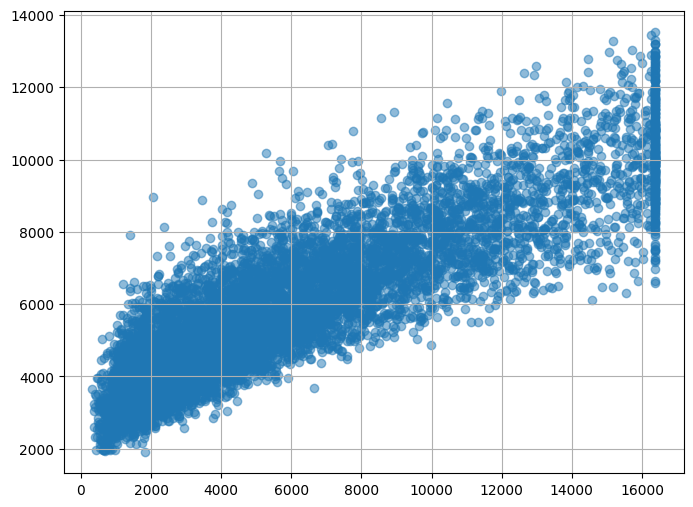

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
train_pred = regressor.predict(X_train)
plt.scatter(y_train, train_pred, alpha=0.5)
plt.grid(True)
plt.show()

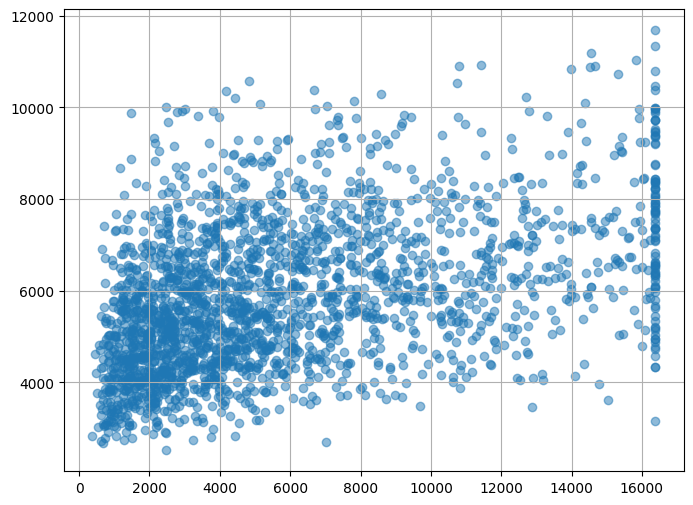

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_val, val_preds, alpha=0.5)
plt.grid(True)
plt.show()

In [1]:
print("hello")

hello


In [5]:
import json
import pandas as pd
with open("problems_with_embeddings.json","r",encoding='utf-8') as file:
    data = json.load(file)

reasoning_lengths = [item['reasoning_length'] for item in data]
df = pd.DataFrame(reasoning_lengths, columns=["reasoning_length"])
df.describe()

,reasoning_length
count,11396.000000
mean,5796.693840
std,4231.018818
min,309.000000
25%,2448.000000
50%,4520.500000
75%,8095.500000
max,16384.000000


In [6]:
quantiles = df["reasoning_length"].quantile([0.2, 0.4, 0.6, 0.8])
print(quantiles)

0.2    2119.0
0.4    3569.0
0.6    5677.0
0.8    9253.0
Name: reasoning_length, dtype: float64


In [12]:
r="""Okay, let's see. The problem says that a regular hexagon can be divided into six equilateral triangles. The perimeter of one of the triangles is 21 inches, and we need to find the perimeter of the regular hexagon. Hmm, okay. Let me try to visualize this. A regular hexagon has all sides equal and all angles equal. If you divide it into six equilateral triangles, each triangle must have sides equal to the sides of the hexagon, right? Because in a regular hexagon, when you connect the center to all the vertices, you create six equilateral triangles. Each of those triangles has two sides that are radii of the circumscribed circle and one side that is a side of the hexagon. Wait, but if the triangles are equilateral, then all sides must be equal. That means the radius of the circumscribed circle (which would be the distance from the center to a vertex) is equal to the side length of the hexagon. So, in this case, each triangle has all three sides equal to the side length of the hexagon. But then, the problem states the perimeter of one of the triangles is 21 inches. Since it's an equilateral triangle, each side is 21 divided by 3, right? So each side is 7 inches. Therefore, the hexagon, which has six sides each of 7 inches, would have a perimeter of 6 times 7, which is 42 inches. Wait, but hold on. Let me double-check that. If each triangle is equilateral, then all three sides are equal. But in the case of the hexagon divided into six triangles from the center, each triangle would have two sides that are radii of the hexagon and one side that is a side of the hexagon. But the problem says the triangles are equilateral. That means all three sides must be equal. Therefore, the radius (distance from center to vertex) must equal the side length of the hexagon. So, in that case, each triangle has sides equal to the side length of the hexagon. Therefore, each triangle's perimeter is 3 times the side length of the hexagon. If that perimeter is 21, then the side length is 7. Then the hexagon has six sides each of 7 inches, so perimeter is 42. Hmm, that seems straightforward. But wait, another thought. Sometimes, when you divide a hexagon into triangles, people might divide it into different types of triangles. For example, maybe splitting it into rhombuses or something else. But the problem specifically says it's divided into six equilateral triangles, so that must be the case where each triangle is equilateral, so each triangle's sides are equal to the side length of the hexagon. Therefore, the perimeter of each triangle is 3 times the hexagon's side length, which is 21. Therefore, the side length is 7, and the perimeter of the hexagon is 6 times that, which is 42. Yeah, that makes sense. Let me check with another approach. Suppose the perimeter of the triangle is 21. Since the triangle is equilateral, each side is 21/3 = 7. Since each side of the triangle is equal to the side of the hexagon, then each side of the hexagon is 7. Therefore, the perimeter of the hexagon is 6*7 = 42. Yep, same answer. So I think the answer is 42. Wait, just to make sure, is there another way someone might interpret dividing a hexagon into triangles? For example, sometimes a hexagon is divided into six isosceles triangles with two sides being radii and the base being the side of the hexagon. But in that case, the triangles would not be equilateral unless the radii are equal to the side length. So if the problem says the triangles are equilateral, that forces the radii to be equal to the side length. Therefore, that must be the case here. So, confirming again: if the triangles are equilateral, then all sides are equal, so the side of the triangle is the same as the radius. Therefore, side length of hexagon is 7, so perimeter is 42. I think that's solid.

**Final Answer**

The perimeter of the regular hexagon is \boxed{42} inches.
"""
from transformers import AutoTokenizer
import torch
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1")

encodings = tokenizer(r, padding=True, truncation=True, return_tensors="pt", max_length=16384)
r_l = torch.sum(encodings['attention_mask'],dim=1)

In [13]:
r_l

tensor([901])

In [ ]:
"test"
import openai 
import json